In [ ]:
%matplotlib inline       

In [ ]:

class Layer(object):
    def __init__(self, units=128, activation = 'relu', dropout = 0):
        self.units = units
        self.posible_activations = ['relu', 'sigmoid', 'tanh', 'elu', 'prelu', 'leakyreLu']
        assert activation in self.posible_activations
        self.activation = activation
        self.dropout = dropout
        self.units_lim = 1024
        self.units_prob = 0.2
        self.act_prob = 0.2
        self.drop_prob = 0.2
        
    def cross(self, other_layer):
        new_units = self.cross_units(other_layer.units)
        new_activation = self.cross_activation(other_layer.activation)
        new_dropout = self.cross_dropout(other_layer.dropout)
        return Layer(new_units, new_activation, new_dropout)
    
    def cross_activation(self, other_activation):
        if np.random.rand() > 0.5:
            return self.activation
        return other_activation
    
    def cross_dropout(self, other_dropout):
        b = np.random.rand()
        return self.dropout * (1 - b) + b * other_dropout
    
    def cross_units(self, other_units):
        b = np.random.rand()
        return int(self.units * (1 - b) + other_units * b)
    
    def mutate(self):
        aleatory = np.random.rand(4)
        if aleatory[0] < self.units_prob:
            self.units = np.random.randint(0, self.units_lim)
        if aleatory[1] < self.act_prob:
            self.activation = random.choice(self.posible_activations)
        if aleatory[2] < self.drop_prob:
            self.dropout = np.random.rand()
            
    def compare(self, other_layer):
        if self.units != other_layer.units:
            return False
        if self.activation != other_layer.activation:
            return False
        if self.dropout != other_layer.dropout:
            return False
        return True
    
    def self_copy(self):
        return Layer(self.units, self.activation, self.dropout)
    
    def random_layer(self):
        units = np.random.randint(0, self.units_lim)
        act = random.choice(self.posible_activations)
        drop = np.random.rand()
        return Layer(units, act, drop)
    
    def __repr__(self):
        return "U:%d|A:%s|D:%0.3f" % (self.units,self.activation, self.dropout)

            
class Cromosome(object):
    
    def __init__(self, layers = []):
        assert type(layers)==list
        self.n_layers = len(layers)
        self.layers = layers
        self.max_layers = 10
        self.layer_prob = 0.1
        
    def cross(self, other_cromosome):
        new_layers = []
        
        if self.n_layers==0:
            return other_cromosome
        '''
        elif other_cromosome.n_layers==0:
            return self
        '''
        
        n_intersection = np.random.randint(0, self.n_layers)
        for i in range(self.n_layers):
            if i<n_intersection or i>=other_cromosome.n_layers:
                new_layers.append(self.layers[i].self_copy())
            else:
                try:
                    new_layers.append(self.layers[i].cross(other_cromosome.layers[i - n_intersection]))
                except IndexError:
                    print("Problem with index %d" % i)
                    print("Intersection point at %d" % n_intersection)
                    print(len(self.layers), self.layers)
                    print(len(other_cromosome.layers), other_cromosome.layers)
                    print(len(new_layers), new_layers)
                    raise IndexError
        return Cromosome(new_layers)
    
    def mutate(self):
        for i in range(self.n_layers):
            self.layers[i].mutate()
        if np.random.rand() < self.layer_prob and self.n_layers<self.max_layers:
            self.layers.append(Layer().random_layer())
            self.n_layers = len(self.layers)
            
    def compare(self, other_cromosome):
        if self.n_layers != other_cromosome.n_layers:
            return False
        for i in range(self.n_layers):
            if not self.layers[i].compare(other_cromosome.layers[i]):
                return False
        return True
    
    def __repr__(self):
        rep = ""
        for i in range(self.n_layers):
            rep += "%d - %s \n" % (i, self.layers[i])
        return rep
    

class GeneticAlgorithm(object):
    
    def __init__(self,fitness_obj, generations=70, num_population=20, num_parents=0.3, mutation_prob=0.7):
        self.num_generations = generations
        self.pop_size = num_population
        self.prob_muta = mutation_prob
        if type(num_parents)==int:
            self.num_parents = num_parents
        else:
            self.num_parents = int(self.pop_size * num_parents)
        self.posible_activations = ['relu', 'sigmoid', 'tanh', 'elu', 'prelu', 'leakyreLu']
        self.Fitness = fitness_obj
        self.offspring_size = self.pop_size - self.num_parents
        self.history = np.empty((self.pop_size, self.num_generations + 1))
        self.history_fitness = {}
        self.fitness_reutilization = 0
        
    def create_random_indiv(self):
        n_layers = np.random.randint(0,2)
        layers = []
        for i in range(n_layers):
            units = np.random.randint(0,512)
            act = random.choice(self.posible_activations)
            drop = np.random.rand()
            layers.append(Layer(units, act, drop))
        return Cromosome(layers)
    
    def create_simple_indiv(self):
        return Cromosome([])
    
    def initial_population(self):
        population = []
        for i in range(0, self.pop_size):
            population.append(self.create_simple_indiv())
        return population
    
    def rank(self, population):
        fitness_result = {}
        for i in range(self.pop_size):
            gen = "%s" % population[i]
            if not gen in self.history_fitness.keys():
                self.history_fitness[gen] = self.Fitness.calc(population[i])
            else:
                self.fitness_reutilization += 1
            fitness_result[i] = self.history_fitness[gen]
        return sorted(fitness_result.items(), key = operator.itemgetter(1), reverse = True)
    
    def select_mating_pool(self, population, rank):
        parents = []
        for i in range(self.num_parents):
            parent_num = rank[i][0]
            parents.append(population[parent_num])
        return parents
    
    def crossover(self, parents, offspring_size):
        offspring = []
        for k in range(offspring_size):
            p1 = np.random.randint(0, len(parents) - 1)
            p2 = np.random.randint(p1 + 1, len(parents))
            parent1 = parents[p1]
            parent2 = parents[p2]
            #parent1 = random.choice(parents)
            #parent2 = random.choice(parents)
            offspring.append(parent1.cross(parent2))
        return offspring
    
    def mutation(self, offspring_crossover):
        for crom in offspring_crossover:
            crom.mutate()
        return offspring_crossover
    
    def actualize_history(self, generation, rank):
        for i in range(len(rank)):
            self.history[i, generation] = rank[i][1]
    
    def show_history(self):
        x = np.linspace(0, self.num_generations, self.num_generations + 1)
        mean = np.mean(self.history, axis=0)
        max_ = np.max(self.history, axis=0)
        min_ = np.min(self.history, axis=0)
        plt.plot(x, mean, label="mean", color='r', lw=1)
        plt.plot(x, max_, label='max', color='b', lw=1)
        plt.plot(x, min_, label='min', color='g', lw=1)
        plt.legend()
        plt.xlabel("num generation")
        plt.ylabel('Fitness')
        plt.show()
    
    def evolve(self, show=True):
        population = self.initial_population()
        for generation in range(self.num_generations + 1):
            ranking = self.rank(population)
            self.actualize_history(generation, ranking)
            if self.num_generations<=10 and show:
                print("%d) best fit: %0.3f" % (generation + 1, ranking[0][1]))
            elif show and (generation % int(self.num_generations / 10) == 0):
                print("%d) best fit: %0.3f" % (generation + 1, ranking[0][1]))
            if generation == self.num_generations:
                break

            # Selecting the best parents in the population for mating.
            parents = self.select_mating_pool(population, ranking)

            # Generating next generation using crossover.
            offspring_crossover = self.crossover(parents, self.offspring_size)

            # Adding some variations to the offsrping using mutation.
            offspring_mutation = self.mutation(offspring_crossover)

            # Creating the new population based on the parents and offspring.
            population[0:self.num_parents] = parents
            population[self.num_parents:] = offspring_mutation
            
        ranking = self.rank(population)
        win_idx = ranking[0][0]
        best_fit = ranking[0][1]
        winner = population[win_idx]
        if show:
            print("Best Gen -> ", winner)
            print("With Fitness: %0.3f" % best_fit)
            print("Number of reutilization fitness: %d" % self.fitness_reutilization)
            self.show_history()
        return winner, best_fit, ranking
    

class ParentSelection(object):
    def __init__(self, mode):
        self.mode = mode
        
    def linear_order(self, rank, ):
        rank = dict(rank)
        idxs = list(rank.keys())
        fitness = list(rank.values())
        probs = np.linspace(len(idxs), 1, len(idxs))
        probs /= np.sum(probs)
        
        winner_idx = self.wheel_selection(probs)
        
    def wheel_selection(self, probs, num_selections=1):
        if np.sum(probs) != 1:
            print("normalizing probs")
            probs /= np.sum(probs)
            
        cumsum = np.cumsum(probs)
        bullets = np.random.rand(num_selections)
        winners = [np.argmax(cumsum>bullets[i]) for i in range(num_selections)]
        return winners
    
def parent_selction(rank, num_parents, selection_type):
    rank = dict(rank)
    idxs = list(rank.keys())
    fitness = list(rank.values())
    
    def rank_probs(idxs):
        probs = np.linspace(len(idxs), 1, len(idxs))
        probs /= np.sum(probs)
        return probs
    
    def fitness_probs(fitness):
        probs = fitness / np.sum(fitness)
        return probs
    
def linear_selection_without_probs(rank, num_parents):
    rank = dict(rank)
    idxs = list(rank.keys())
    fitness = list(rank.values())
    valid_idxs = idxs[:num_parents]
    num_offspring = len(idxs) - len(valid_idxs)
    parents = []
    for i in range(num_offspring):
        parent_1 = random.choice(valid_idxs)
        parent_2 = random.choice(valid_idxs)
        while parent_1 == parent_2:
            parent_2 = random.choice(valid_idxs)
        parents.append((parent_1, parent_2))
    
def linear_order_with_probs(rank, num_parents):
    rank = dict(rank)
    idxs = list(rank.keys())
    fitness = list(rank.values())
    
    probs = np.linspace(len(idxs), 1, len(idxs))
    num_offspring = len(idxs) - num_parents
    parents_1 = random.choices(idxs, weights=probs, k=num_parents)
    parents_2 = random.choices(idxs, weights=probs, k=num_parents)
    parents = []
    for i in range(num_offspring):
        while parents_1[i] == parents_2[i]:
            parents_2[i] = random.choice(idxs)
        parents.append((parents_1[i], parents_2[i]))
    return parents
        

    
class Fitness_str():
    
    def __init__(self, crom_objective):
        self.crom = crom_objective
        self.str = "%s" % self.crom
        
    def calc(self, crom):
        C_str = "%s" % crom
        min_lenght = min(len(C_str), len(self.str))
        max_lenght = max(len(C_str), len(self.str))
        f = max_lenght - min_lenght
        for i in range(min_lenght):
            f += self.str[i] != C_str[i]
        return -f
    

        

In [69]:

        
def wheel_selection(probs, num_selections=1):
    cumsum = np.cumsum(probs)
    bullets = np.random.rand(num_selections)
    winners = [np.argmax(cumsum>b) for b in bullets]
    return winners
    


n_samples = 10
idxs = np.random.permutation(np.linspace(0, n_samples -1, n_samples))
fitness = np.linspace(n_samples, 1, n_samples)
fitness /= np.sum(fitness)

print(idxs)
print(fitness)


[7. 1. 9. 0. 4. 2. 3. 6. 8. 5.]
[0.18181818 0.16363636 0.14545455 0.12727273 0.10909091 0.09090909
 0.07272727 0.05454545 0.03636364 0.01818182]


In [70]:
probs = np.linspace(len(idxs), 1, len(idxs))
num_offspring = len(idxs) - len(valid_idxs)
parents_1 = random.choices(idxs, weights=probs, k=num_parents)
parents_2 = random.choices(idxs, weights=probs, k=num_parents)
parents = []
for i in range(num_offspring):
    while parents_1[i] == parents_2[i]:
        parents_2[i] = random.choice(idxs)
    parents.append((parents_1[i], parents_2[i]))

NameError: name 'valid_idxs' is not defined

In [59]:
b

In [55]:
n_samples = 10
idxs = np.random.permutation(np.linspace(0, n_samples -1, n_samples))
fitness = np.linspace(n_samples, 1, n_samples)

ti = time()
for i in range(N_iters):
    s2 = random.choices(idxs, weights=fitness, k=N_samples)
print("tiempo de calentamiento: %0.3f" % (time()- ti))
ti = time()
for i in range(N_iters):
    s2 = random.choices(idxs, weights=fitness, k=N_samples)
print("tiempo the rial: %0.3f" % (time()- ti))

tiempo de calentamiento: 0.358
tiempo the rial: 0.354


In [56]:
frecs2 = np.array([np.sum(s2 == idx) for idx in idxs])
print(frecs2/N)

[0.17897 0.16338 0.14785 0.12763 0.10828 0.091   0.07376 0.05426 0.03728
 0.01759]


(0.0, 2240.0)

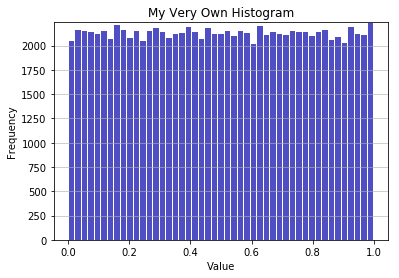

In [41]:
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
d = np.random.rand(100000)
n, bins, patches = plt.hist(x=d, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('My Very Own Histogram')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [71]:
l = Layer(758, 'elu', 0.86)
l2 = Layer(32, 'prelu', 0.32)
l3 = Layer(128, 'relu', 0.5)
c = Cromosome([l,l2, l3])

In [75]:
c.__repr__()

'0 - U:758|A:elu|D:0.860 \n1 - U:32|A:prelu|D:0.320 \n2 - U:128|A:relu|D:0.500 \n'

1) best fit: -77.000
501) best fit: -3.000
1001) best fit: -2.000
1501) best fit: -1.000
2001) best fit: -1.000
2501) best fit: -1.000
3001) best fit: -1.000
3501) best fit: -1.000
4001) best fit: -1.000
4501) best fit: 0.000
5001) best fit: 0.000
Best Gen ->  0 - U:758|A:elu|D:0.860 
1 - U:32|A:prelu|D:0.320 
2 - U:128|A:relu|D:0.500 

With Fitness: 0.000
Number of reutilization fitness: 175098


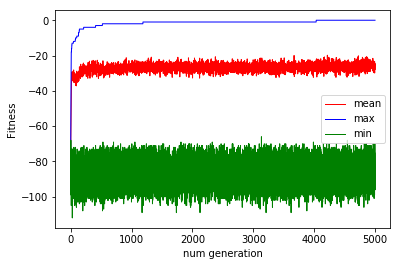

In [58]:
ga = GeneticAlgorithm(Fitness_str(c), generations=5000, num_population=100, num_parents=0.3)

win, fit, rank_l = ga.evolve()

In [32]:
print(type(rank_l))

for b in rank_l:
    print(b)

<class 'list'>
(9, -34)
(0, -39)
(3, -39)
(4, -42)
(1, -43)
(8, -43)
(5, -44)
(2, -48)
(7, -50)
(6, -67)


In [37]:
rank = dict(rank_l)
print(type(rank))
for k,v in rank.items():
    print(k, v)
    
idxs = list(rank.keys())
fitness = list(rank.values())
probs = fitness / np.sum(fitness)

print(idxs)
print(fitness)
p = fitness / np.sum(fitness)
print(p)
cumsum = np.cumsum(p)
print(cumsum)

bullet = np.random.rand()
print(bullet)

stair = cumsum > bullet
print(stair)
winner = np.argmax(stair)
print(winner)
winner_idx = idxs[winner]
print(winner_idx)

<class 'dict'>
9 -34
0 -39
3 -39
4 -42
1 -43
8 -43
5 -44
2 -48
7 -50
6 -67


In [49]:
a = np.random.rand?
print(a)

[]


In [ ]:
print(c)
print(win)

### Data Manager

This database administrator allows to use a subset of the complete database, that is, to select a more limited number of training examples or a smaller number of classes.

In [3]:

class DataManager(object):
    
    def __init__(self, name='mnist', max_examples=None, clases=[],  num_clases=10, train_split=0.8):
        assert name in ['mnist', 'fashion_mnist', 'cifar10', 'cifar100']
        self.name = name
        if len(clases) > 0:
            self.num_clases = len(clases)
        else: 
            self.num_clases = num_clases
        self.max_examples = max_examples
        self.clases = clases
        self.train_split = train_split
        
    def load_data(self):
        if self.name == 'mnist':
            data = mnist.load_data()
        elif self.name == 'fashion_mnist':
            data = fashion_mnist.load_data()
        elif self.name == 'cifar10':
            data = cifar10.load_data()
        else:
            data = cifar100.load_data()
            
        train_data, test_data = self.select_clases(data) 
        x_train, y_train = self.limit_examples(train_data)
        x_test, y_test = test_data

        del data, test_data, train_data
        
        x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.
        x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.

        y_train, y_test = self.encode(y_train, y_test)        
        y_train = to_categorical(y_train, self.num_clases)
        y_test = to_categorical(y_test, self.num_clases)
        
        (x_train, y_train), (x_val, y_val) = self.split(x_train, y_train, self.train_split)
        self.x_train = x_train
        self.x_test = x_test
        self.x_val = x_val
        self.y_train = y_train
        self.y_test = y_test
        self.y_val = y_val
        print(x_train.shape, 'train samples')
        print(x_val.shape, 'validation samples')
        print(x_test.shape, 'test samples')
        return (self.x_train, self.y_train), (self.x_test, self.y_test), (self.x_val, self.y_val)
        
    def encode(self, y_train, y_test):
        self.encoder = {}
        self.decoder = {}
        clases = sorted(self.count_clases(y_train))
        for i in range(len(clases)):
            self.encoder[clases[i]] = i
            self.decoder[i] = clases[i]
            
        y_train = [self.encoder[l] for l in y_train]
        y_test = [self.encoder[l] for l in y_test]
        return y_train, y_test
            
        
    def limit_examples(self, data):
        examples = len(data[1])
        if self.max_examples is None or examples < self.max_examples:
            return data
        ids = np.random.permutation(examples)
        return (data[0][ids[:self.max_examples]], data[1][ids[:self.max_examples]])
        
    
    def select_clases(self, data):
        data_clases = self.count_clases(data[0][1])
        if len(data_clases) <= self.num_clases:
            self.num_clases = len(data_clases)
            return data
        if len(self.clases) == 0:
            all_clases = np.random.permutation(len(data_clases))
            sel_id = all_clases[:self.num_clases]
            sel = data_clases[sel_id]
        else:
            sel = self.clases
        idx_train = np.array([i for i in range(len(data[0][1])) if data[0][1][i] in sel])
        idx_test = np.array([i for i in range(len(data[1][1])) if data[1][1][i] in sel])
        return (data[0][0][idx_train], data[0][1][idx_train]), (data[1][0][idx_test], data[1][1][idx_test])
            
        
    def count_clases(self, labels):
        classes = []
        for label in labels:
            if not label in classes:
                classes.append(label)
        return np.array(classes)
        
    def decode(self, onehot_labels):
        decoded_labels = []
        if onehot_labels.ndim == 2:
            n_ex, n_clases = onehot_labels.shape
            for i in range(n_ex):
                decoded_labels.append(self.decoder[np.argmax(onehot_labels[i])])
        else:
            decoded_labels.append(self.decoder[np.argmax(onehot_labels)])
        return np.array(decoded_labels)
    
    def split(self, data, labels, train_split):
        idx = np.random.permutation(data.shape[0])
        s = int(train_split * data.shape[0])
        return (data[:s], labels[:s]), (data[s:], labels[s:])


In [4]:
dm = DataManager('mnist', clases=[4,9])
(x_train, y_train), (x_test, y_test), (x_val, y_val) = dm.load_data()

(9432, 28, 28, 1) train samples
(2359, 28, 28, 1) validation samples
(1991, 28, 28, 1) test samples


In [7]:
print(x_train.shape, x_test.shape, x_val.shape)

print(y_train.shape, y_test.shape, y_val.shape)

(14400, 28, 28, 1) (3000, 28, 28, 1) (3600, 28, 28, 1)
(14400, 3) (3000, 3) (3600, 3)


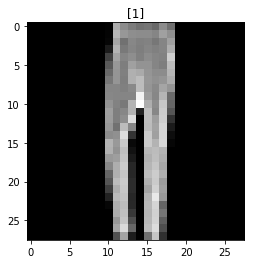

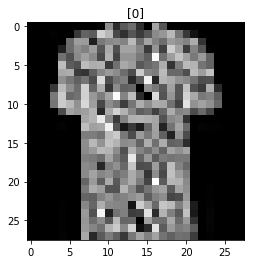

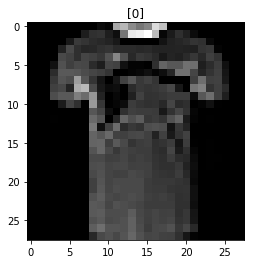

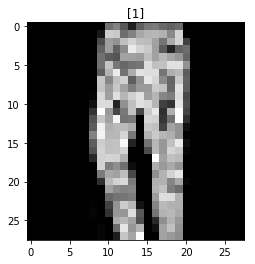

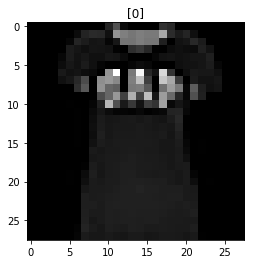

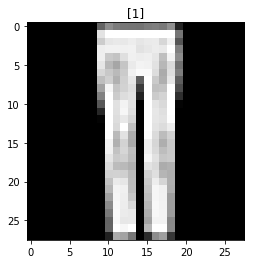

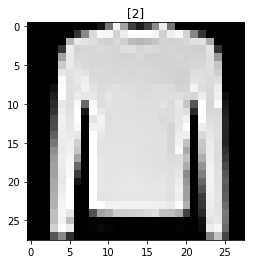

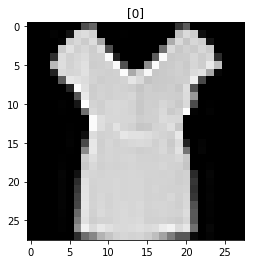

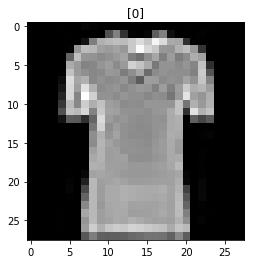

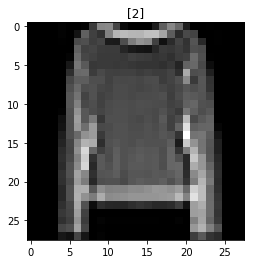

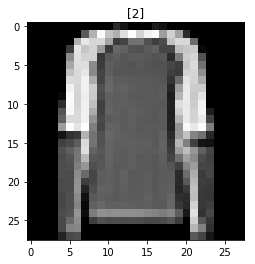

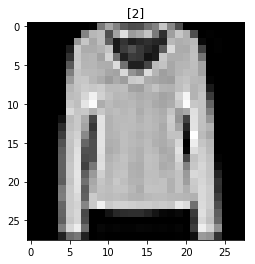

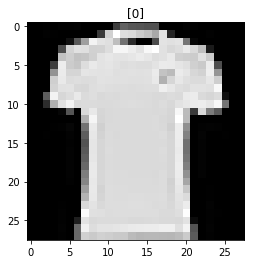

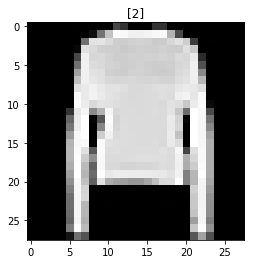

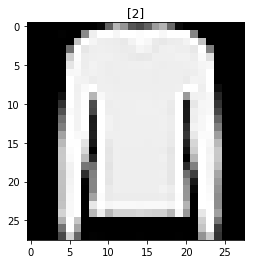

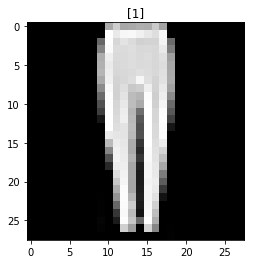

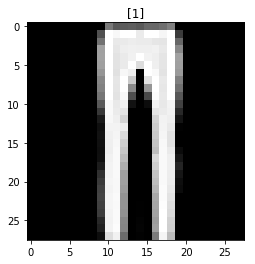

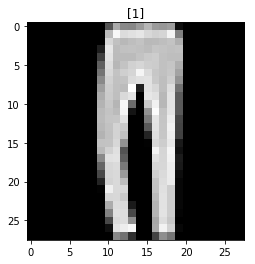

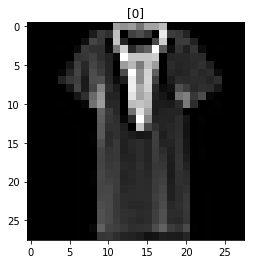

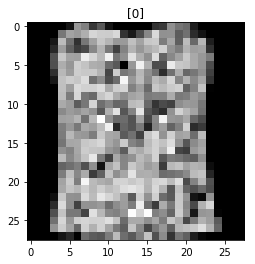

In [8]:
for i in range(20):
    plt.imshow(x_val[i].reshape(28,28), cmap='gray')
    plt.title(dm.decode(y_val[i,:]))
    plt.show()

### Training a single Net

In [63]:
class Fitness():
    
    def __init__(self, data, batch_size=128, epochs=100, early_stop=True, reduce_plateu=True, verbose=1):
        self.batch_size = batch_size
        self.epochs = epochs
        self.early_stop = early_stop
        self.reduce_plateu = reduce_plateu
        self.verb = verbose
        (self.x_train, self.y_train), (self.x_test, self.y_test), (self.x_val, self.y_val) = data
        self.num_clases = self.y_train.shape[1]
        self.callbacks = []
        if self.early_stop:
            self.callbacks.append(EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True))
        if self.reduce_plateu:
            self.callbacks.append(ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=5, verbose=self.verb))
        
    def calc(self, chromosome):
        model = self.decode(chromosome)
        h = model.fit(self.x_train, self.y_train,
                    batch_size=self.batch_size,
                    epochs=self.epochs,
                    verbose=self.verb,
                    validation_data=(self.x_val, self.y_val),
                    callbacks = self.callbacks)
        score = model.evaluate(self.x_val, self.y_val, verbose=0)
        score_t = model.evaluate(self.x_test, self.y_test, verbose=0)
        if self.verb:
            print('Val loss: %0.4f, Test loss: %0.4f' % (score[0], score_t[0]))
            print('Val accuracy: %0.4f, Test accuracy: %0.4f' % (score[1], score_t[1]))
            self.show_result(h, 'acc')
            self.show_result(h, 'loss')
        return score[1]
    
        
    def decode(self, chromosome):
        
        inp = Input(shape=(28,28,1))
        x = Flatten()(inp)
        for i in range(chromosome.n_layers):
            act = chromosome.layers[i].activation
            if act in ['relu', 'sigmoid', 'tanh', 'elu']:
                x = Dense(chromosome.layers[i].units, activation=act)(x)
            elif act == 'prelu':
                x = Dense(chromosome.layers[i].units)(x)
                x = PReLU()(x)
            else:
                x = Dense(chromosome.layers[i].units)(x)
                x = LeakyReLU()(x)
            x = Dropout(chromosome.layers[i].dropout)(x)
        x = Dense(self.num_clases, activation='softmax')(x)
        
        model = Model(inputs=inp, outputs=x)
        if self.verb:
            model.summary()
        model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
        return model
    
    def show_result(self, history, metric='acc'):
        epochs = np.linspace(0, len(history.history['acc']) - 1, len(history.history['acc']))
        plt.plot(epochs, history.history['val_%s'%metric], label='validation')
        plt.plot(epochs, history.history[metric], label='train')
        plt.legend()
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.show()
            
    def calc_mean(self, chromosome, iters=5):
        f = []
        ti = time()
        for i in range(iters):
            f.append(self.calc(chromosome))
        print("Acc: %0.3f" % np.mean(f), np.std(f), np.max(f))
        print("Time elapsed: %0.3f" % (time() - ti))

In [66]:
l = Layer(516, 'relu', 0.2)
l2 = Layer(516, 'relu', 0.2)
l3 = Layer(128, 'relu', 0.2)
c = Cromosome([l,l2, l3])
c = Cromosome([l, l2])
clases = [4,9]
dm = DataManager(clases=clases)
data = dm.load_data()
fitness = Fitness(data, verbose=0, reduce_plateu=False)

(9432, 28, 28, 1) train samples
(2359, 28, 28, 1) validation samples
(1991, 28, 28, 1) test samples


In [67]:
fitness.calc_mean(c)

Acc: 0.991 0.000758310462907942 0.9919457398212881
Time elapsed: 287.443


In [51]:
fitness.calc_mean(Cromosome([]))

Acc: 0.972 0.000494357939367995 0.9728698602112839
Time elapsed: 160.356


In [68]:
l = Layer(512, 'relu', 0.2)
l1 = Layer(128, 'relu', 0.346)
l2 = Layer(178, 'relu', 0.018)
c = Cromosome([l, l1, l2])
fitness.calc_mean(c)

Acc: 0.990 0.001180872257497582 0.9915218313855102
Time elapsed: 214.332


In [68]:
clases = [4,7,9]
dm = DataManager(clases=clases)
data = dm.load_data()
fitness = Fitness(data, verbose=0)
ga = GeneticAlgorithm(fitness, generations=40, num_population=10, num_parents=0.4)
ti = time()
win, fit = ga.evolve()
print("Time elapsed: %0.2f" % (time() - ti))

(14444, 28, 28, 1) train samples
(3612, 28, 28, 1) validation samples
(3019, 28, 28, 1) test samples
1) best fit: 0.957
5) best fit: 0.991
9) best fit: 0.991
13) best fit: 0.991
17) best fit: 0.991
21) best fit: 0.991
25) best fit: 0.991
29) best fit: 0.991
33) best fit: 0.991


AssertionError: 

In [ ]:
d = ga.history_fitness

d2 = dict(sorted(d.items(), key=operator.itemgetter(1), reverse=True))
for k,v in d2.items():
    print("Fitness: %0.4f" % v)
    print("Model: \n%s" % k)

In [62]:
v = keras.__version__
type(v)

str

In [64]:
print(v=='2.2.4')

True
